<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [97]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn import metrics, linear_model
from sklearn.linear_model import LogisticRegression, ElasticNetCV, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report,precision_score,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.datasets import make_imbalance

from collections import Counter

from matplotlib import pyplot
from sklearn.grid_search import GridSearchCV

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [98]:
# Load the data
house = pd.read_csv('./housing.csv')

In [99]:
description = open('./data_description.txt', 'r') 
print description.read()

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [100]:
house.columns


Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [101]:
house['MSZoning'].value_counts()


RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [102]:
# Dropping all non_residential properties.
house = house[house['MSZoning'].values != 'C (all)']

In [103]:
# Checking for null values.
house.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [104]:
# Dropping columns that have more than 653 (45%) null values.

house.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1, 
           inplace=True)

In [105]:
# filling null values with median value of this column

house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace = True)

In [106]:
# Dropping all rows with NaN values after having checked that they relate to
# similar features so that there is still a reasonable amount of datapoints left.

house.dropna(subset = ['GarageCond','GarageType','GarageYrBlt','GarageFinish',
                       'GarageQual','BsmtExposure','BsmtFinType2','BsmtFinType1',
                       'BsmtCond','BsmtQual','MasVnrType','MasVnrArea',
                       'Electrical'], inplace=True)

In [107]:
house.shape

(1330, 76)

# Feature Selection and Engineering

## Feature Engineering

In [108]:
# The age of a house may affect its price.

house['HouseAge'] = house['YrSold'] - house['YearRemodAdd']
house.drop(['YearBuilt','YearRemodAdd'], axis=1, inplace=True)

## Feature Selection

- Creation of different dataframes for different types of data (e.g. catagorical, numerical).


- The dataframes created are only created for ease of reviewing and sorting data. They are not used once feature selection is over. 

In [109]:
# The data will be split into 4 different classes (catagorical,spacial,temoral, 
# numerical and financial).

categorical_columns = ['MSSubClass','MSZoning','Street','LotShape','LandContour',
                    'Utilities','LotConfig','LandSlope','Neighborhood',
                    'Condition1','Condition2','BldgType','HouseStyle',
                    'OverallQual','OverallCond','RoofStyle','RoofMatl',
                    'Exterior1st','Exterior2nd','MasVnrType','ExterQual',
                    'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure',
                    'BsmtFinType1','BsmtFinType2','Heating','HeatingQC',
                    'CentralAir','Electrical','BsmtFullBath','BsmtHalfBath',
                    'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                    'KitchenQual','TotRmsAbvGrd','Functional','GarageType',
                    'GarageFinish','GarageQual','GarageCond','PavedDrive',
                    'MoSold','SaleType','SaleCondition']

area_columns = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
               'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
               'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                '3SsnPorch','ScreenPorch','PoolArea',]

year_columns = ['GarageYrBlt','YrSold','HouseAge']

numerical_columns = ['Fireplaces','GarageCars']

non_monetary_columns = area_columns + year_columns + numerical_columns + categorical_columns

# Categorical data will have to be dummified (if not otherwise dropped). 

house_categorical = house[categorical_columns]
house_monetary = house.drop(non_monetary_columns, axis=1)
house_area = house[area_columns]
house_year = house[year_columns]
house_numerical = house[numerical_columns]

In [110]:
house_monetary.head()

,Id,MiscVal,SalePrice
0,1,0,208500
1,2,0,181500
2,3,0,223500
3,4,0,140000
4,5,0,250000


In [111]:
# Since most of the MiscVal column are 0s, this column can be dropped.

house_monetary['MiscVal'].value_counts()

0        1285
400        10
500         7
700         5
2000        4
600         4
450         3
480         2
1150        1
800         1
15500       1
620         1
1400        1
1200        1
2500        1
1300        1
350         1
8300        1
Name: MiscVal, dtype: int64

In [112]:
# These are dataframes that contain information relating to different areas of
# different parts of houses (e.g. basement, non-basement).

house_area_bsmt = house_area[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
house_area_non_bsmt = house_area[['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea']]
house_area_totals = house_area[['LotArea','LotFrontage','TotalBsmtSF','GrLivArea',
                               'GarageArea','WoodDeckSF','OpenPorchSF',
                               'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']]

In [113]:
print house_area_bsmt.head(10)

house_area_bsmt[house_area_bsmt['BsmtFinSF1'] + 
                house_area_bsmt['BsmtFinSF2'] + 
                house_area_bsmt['BsmtUnfSF'] != house_area_bsmt['TotalBsmtSF']]

# We can see that the total basement area is the sum of BsmtFinSF1 + BsmtFinSF2
# and BsmtUnfSF. We can therefore drop those 3 columns and just keep the total.

   BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF
0         706           0        150          856
1         978           0        284         1262
2         486           0        434          920
3         216           0        540          756
4         655           0        490         1145
5         732           0         64          796
6        1369           0        317         1686
7         859          32        216         1107
8           0           0        952          952
9         851           0        140          991


,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF


In [114]:
print house_area_non_bsmt.head()

house_area_non_bsmt[house_area_non_bsmt['1stFlrSF'] + 
                    house_area_non_bsmt['2ndFlrSF'] + 
                    house_area_non_bsmt['LowQualFinSF'] != house_area_non_bsmt['GrLivArea']]

# As with the basement area, we need only keep GrLivArea.

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea
0       856       854             0       1710
1      1262         0             0       1262
2       920       866             0       1786
3       961       756             0       1717
4      1145      1053             0       2198


,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea


In [115]:
house_area_totals.head()

,LotArea,LotFrontage,TotalBsmtSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
0,8450,65.0,856,1710,548,0,61,0,0,0,0
1,9600,80.0,1262,1262,460,298,0,0,0,0,0
2,11250,68.0,920,1786,608,0,42,0,0,0,0
3,9550,60.0,756,1717,642,0,35,272,0,0,0
4,14260,84.0,1145,2198,836,192,84,0,0,0,0


In [116]:
print house_area['GarageArea'].unique()

[ 548  460  608  642  836  480  636  484  468  205  384  736  352  840  576
  294  853  280  534  572  270  890  772  319  240  271  447  556  691  672
  498  246  440  308  504  300  670  826  386  388  528  516  894  565  641
  288  645  852  558  220  667  360  427  490  379  297  283  509  405  758
  461  400  462  432  684  420  472  366  476  740  648  273  250  546  325
  792  450  180  430  594  390  540  264  530  435  453  750  487  624  471
  318  766  660  470  720  577  380  434  866  495  564  312  680  678  726
  532  216  303  789  511  616  521  451 1166  497  682  666  786  795  856
  473  398  500  349  454  644  299  210  431  438  675  968  721  336  810
  494  457  818  463  604  389  538  520  309  429  673  884  868  492  413
  924 1053  439  671  338  573  732  505  575  626  898  529  685  281  539
  418  588  282  375  683  843  552  870  888  746  708  410  513 1025  656
  872  292  441  189  676  301  474  706  617  445  200  592  566  514  296
  244  610  

In [117]:
print house_area['WoodDeckSF'].value_counts()
print house_area['OpenPorchSF'].value_counts()
print house_area['EnclosedPorch'].value_counts()
print house_area['3SsnPorch'].value_counts()
print house_area['ScreenPorch'].value_counts()

# As many of the values (more than 50%) for these porch areas are 0, it has been
# decided that they shall be dropped.

0      663
192     38
100     35
144     31
120     29
168     28
224     14
140     14
208     10
240     10
216      8
160      8
180      8
250      6
156      6
264      6
132      6
143      6
48       5
196      5
105      5
96       5
210      5
171      5
74       4
64       4
104      4
288      4
147      4
158      4
      ... 
190      1
187      1
186      1
183      1
248      1
255      1
257      1
260      1
340      1
333      1
328      1
327      1
326      1
325      1
312      1
309      1
307      1
306      1
305      1
304      1
303      1
301      1
298      1
295      1
294      1
283      1
278      1
269      1
265      1
218      1
Name: WoodDeckSF, Length: 265, dtype: int64
0      568
36      28
48      21
20      19
40      19
45      17
60      15
30      15
24      14
39      14
50      13
44      13
28      13
72      12
54      11
35      11
63      11
32      10
98      10
75      10
42       9
120      9
64       9
66       9
68       8
38       8

In [118]:
house_area['PoolArea'].value_counts()

# Likewise for the values for poolarea.

0      1323
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

In [119]:
# Non-categorical columns to be dropped from main dataframe

to_drop = ['MiscVal','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
           'ScreenPorch','PoolArea']

house.drop(to_drop,axis=1,inplace=True)

In [120]:
# These are the shortlisted fixed features:

features = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street',
                  'LotShape','LandContour','Utilities','LotConfig','LandSlope',
                  'Neighborhood','Condition1','Condition2','BldgType',
                  'HouseStyle','Foundation','BsmtExposure','BsmtFullBath',
                  'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
                  'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType',
           'TotalBsmtSF','GrLivArea','GarageArea']

# Fixed features that can be dropped on account of being boring:
# Street, LandContour,Utilities, landslope,condition1,condition2,buildingtype,
# BsmtHalfBath and KitchenAbvGr.

# These are the revised fixed features:

fixed_features = ['MSSubClass','MSZoning','LotFrontage','LotArea','LotShape',
                  'LotConfig','Neighborhood','HouseStyle','Foundation',
                  'BsmtExposure','BsmtFullBath','FullBath','HalfBath',
                  'BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageType',
                  'TotalBsmtSF','GrLivArea','GarageArea']

In [121]:
# Get dummies for subclass of properties.
sub_class_dummies = pd.get_dummies(house['MSSubClass'])

# Dropping the reference column (column 40 as it only has 4 values)
sub_class_dummies = sub_class_dummies.drop(40,axis = 1)

In [122]:
# Repeating the above 2 steps for all fixed features with categorical values. 
# Dropping the column with least values as reference column.

# MSZoning
zoning_dummies = pd.get_dummies(house['MSZoning'])
zoning_dummies.drop('RH', axis = 1, inplace = True)

# LotShape
lotshape_dummies = pd.get_dummies(house['LotShape'])
lotshape_dummies.drop('IR3', axis = 1, inplace = True)

# LotConfig
lotconfig_dummies = pd.get_dummies(house['LotConfig'])
lotconfig_dummies.drop('FR3', axis = 1, inplace = True)

# Neighbourhood
neighbourhood_dummies = pd.get_dummies(house['Neighborhood'])
neighbourhood_dummies.drop('Blueste', axis = 1, inplace = True)

# House Style
housestyle_dummies = pd.get_dummies(house['HouseStyle'])
housestyle_dummies.drop('2.5Fin', axis = 1, inplace = True)

# Foundation
foundation_dummies = pd.get_dummies(house['Foundation'])
foundation_dummies.drop('Wood', axis = 1, inplace = True)

# BsmtExposure
bsmtex_dummies = pd.get_dummies(house['BsmtExposure'])
bsmtex_dummies.drop('Mn', axis = 1, inplace = True)

# GarageType
garagetype_dummies = pd.get_dummies(house['GarageType'])
garagetype_dummies.drop('2Types', axis = 1, inplace = True)

In [123]:
house_fixed_features = house[['MSSubClass','MSZoning','LotFrontage','LotArea',
                              'LotShape','LotConfig','Neighborhood','HouseStyle',
                              'Foundation','BsmtExposure','BsmtFullBath',
                              'TotalBsmtSF','GrLivArea','GarageArea',
                              'FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd',
                              'Fireplaces','GarageType','YrSold','SalePrice']]

# Dropping categorical columns

house_fixed_features.drop(['MSSubClass','MSZoning','LotShape','LotConfig',
                           'Neighborhood','HouseStyle','Foundation',
                           'BsmtExposure','GarageType'],axis=1,inplace=True)

C:\Users\OJ\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [124]:
house_fixed_features = pd.concat([house_fixed_features,sub_class_dummies,
                                  zoning_dummies,lotshape_dummies,
                                  lotconfig_dummies,neighbourhood_dummies,
                                  housestyle_dummies,foundation_dummies,
                                  bsmtex_dummies,garagetype_dummies], axis=1)

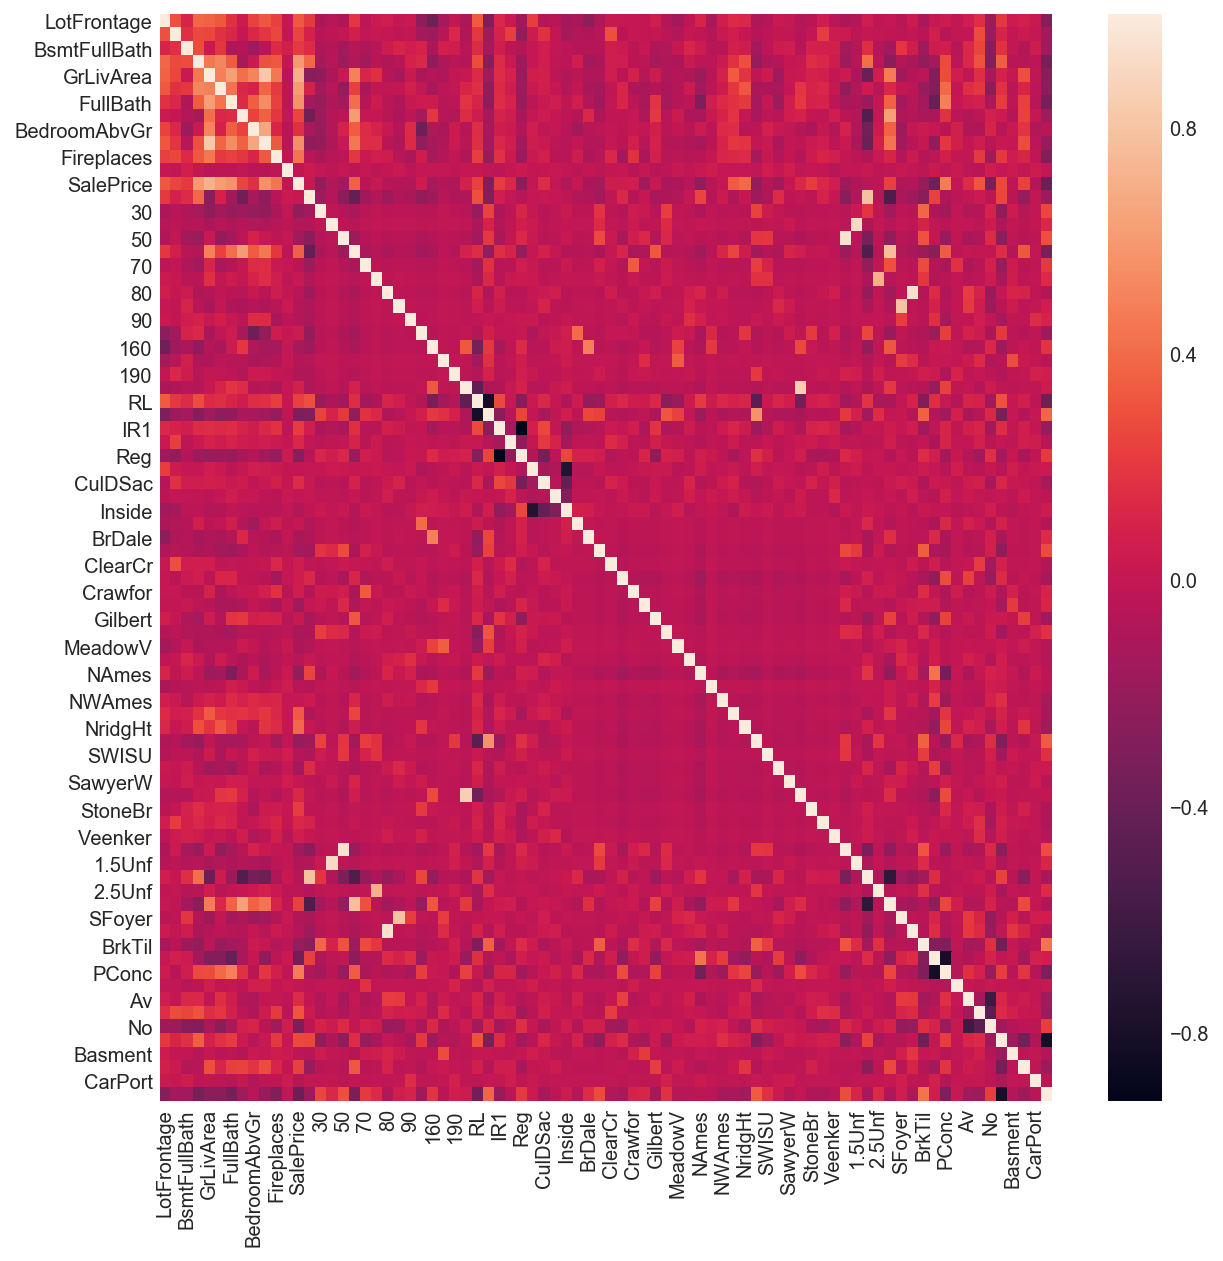

In [125]:
fig, ax = pyplot.subplots(figsize=(10,10))
sns.heatmap(house_fixed_features.corr())

# Model Building

In [126]:
fixed_train_pd = house_fixed_features[house_fixed_features['YrSold'] < 2010]
fixed_test_pd = house_fixed_features[house_fixed_features['YrSold'] == 2010]

In [127]:
fixed_predictors = [x for x in fixed_train_pd.columns if x != 'SalePrice']

y_train = fixed_train_pd['SalePrice']
X_train = fixed_train_pd[fixed_predictors]

y_test = fixed_test_pd['SalePrice']
X_test = fixed_test_pd[fixed_predictors]


In [128]:
model = sm.OLS(y_train,X_train).fit()

In [129]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     506.9
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        02:10:04   Log-Likelihood:                -13875.
No. Observations:                1173   AIC:                         2.791e+04
Df Residuals:                    1094   BIC:                         2.831e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
LotFrontage   -129.8785     63.616     -2.042      0.041    -254.702      -5.055
LotArea          0.2902      0.122      2.385      0.017       0.051       0.529
BsmtFullBath  9919.7365   2316.249      4.283      0.000    5374.944    1.45e+04
TotalBsmtSF      0.6258      5.546      0.113      0.910     -10.256      11.508
GrLivArea       65.9039      6.302     10.458      0.000      53.538      78.269
GarageArea      33.7666      8.130      4.153      0.000      17.815      49.718
FullBath       1.23e+04   3424.565      3.591      0.000    5577.907     1.9e+04
HalfBath      8646.7307   3227.437      2.679      0.007    2314.063     1.5e+04
BedroomAbvGr -7808.0464   2151.830     -3.629      0.000    -1.2e+04   -3585.866
TotRmsAbvGrd  3861.9173   1454.183      2.656      0.008    1008.615    6715.220
Fireplaces    6878.4504   2044.247      3.365      0.001    2867.361    1.09e+04
YrSold         -54.0765     28.824     -1.876      0.061    -110.632       2.479
20            1.984e+04   2.06e+04      0.964      0.335   -2.05e+04    6.02e+04
30            2549.7395   2.09e+04      0.122      0.903   -3.84e+04    4.35e+04
45           -4431.6900    3.5e+04     -0.127      0.899   -7.31e+04    6.43e+04
50            2.178e+04    2.5e+04      0.872      0.383   -2.72e+04    7.08e+04
60            1.936e+04   2.45e+04      0.791      0.429   -2.87e+04    6.74e+04
70            1.867e+04   2.42e+04      0.773      0.440   -2.87e+04    6.61e+04
75            2.919e+04   3.13e+04      0.934      0.350   -3.21e+04    9.05e+04
80            4870.1783    2.7e+04      0.180      0.857   -4.82e+04    5.79e+04
85             744.5969   2.71e+04      0.027      0.978   -5.24e+04    5.39e+04
90           -2.737e+04   2.29e+04     -1.197      0.232   -7.22e+04    1.75e+04
120          -1.433e+04   2.11e+04     -0.677      0.498   -5.58e+04    2.72e+04
160          -2.115e+04   2.53e+04     -0.835      0.404   -7.08e+04    2.85e+04
180          -2.585e+04   2.93e+04     -0.883      0.378   -8.33e+04    3.16e+04
190          -1.051e+04   2.34e+04     -0.449      0.653   -5.64e+04    3.54e+04
FV            1636.2140   1.49e+04      0.110      0.912   -2.76e+04    3.08e+04
RL           -3111.9790   1.15e+04     -0.271      0.786   -2.56e+04    1.94e+04
RM            4086.7653   1.26e+04      0.325      0.746   -2.06e+04    2.88e+04
IR1           3.387e+04   1.21e+04      2.802      0.005    1.02e+04    5.76e+04
IR2           4.909e+04   1.31e+04      3.742      0.000    2.33e+04    7.48e+04
Reg           3.424e+04   1.22e+04      2.813      0.005    1.04e+04    5.81e+04
Corner        2.209e+04   1.79e+04      1.237      0.217    -1.3e+04    5.71e+04
CulDSac       3.185e+04   1.83e+04      1.736      0.083   -4143.232    6.78e+04
FR2           1.004e+04   1.85e+04      0.542      0.588   -2.63e+04    4.64e+04
Insid

In [130]:
# Dropping columns with p values higher than 0.05

house_fixed_features.drop([20,30,45,50,60,70,75,80,85,90,120,160,180,190,'Corner',
                     'CulDSac','FR2','Inside','Blmngtn','BrDale','BrkSide',
                     'ClearCr','CollgCr','Crawfor','Edwards','Gilbert','IDOTRR',
                     'MeadowV','Mitchel','NAmes','NPkVill','NWAmes','OldTown',
                     'SWISU','Sawyer','SawyerW','Somerst','Timber','Veenker',
                     '1.5Fin','1.5Unf','1Story','2.5Unf','2Story','SFoyer','SLvl',
                     'BrkTil','CBlock','PConc','Stone','Av','No','Basment',
                     'CarPort','RL','RM','HalfBath','LotFrontage','LotArea'],
                    axis=1,inplace=True)

In [131]:
fixed_train_pd = house_fixed_features[house_fixed_features['YrSold'] < 2010]
fixed_test_pd = house_fixed_features[house_fixed_features['YrSold'] == 2010]

In [132]:
fixed_predictors = [x for x in fixed_train_pd.columns if x != 'SalePrice']

y_train = fixed_train_pd['SalePrice']
X_train = fixed_train_pd[fixed_predictors]

y_test = fixed_test_pd['SalePrice']
X_test = fixed_test_pd[fixed_predictors]

model = sm.OLS(y_train,X_train).fit()

In [133]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1599.
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        02:10:04   Log-Likelihood:                -14032.
No. Observations:                1173   AIC:                         2.810e+04
Df Residuals:                    1153   BIC:                         2.821e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
BsmtFullBath  8892.9636   2396.839      3.710      0.000    4190.309    1.36e+04
TotalBsmtSF     21.8804      3.833      5.708      0.000      14.359      29.402
GrLivArea       45.6346      4.864      9.381      0.000      36.090      55.179
GarageArea      62.3932      7.825      7.974      0.000      47.041      77.745
FullBath      1.365e+04   2915.473      4.683      0.000    7932.646    1.94e+04
BedroomAbvGr -1.072e+04   2068.537     -5.183      0.000   -1.48e+04   -6663.430
TotRmsAbvGrd  5198.1517   1487.745      3.494      0.000    2279.162    8117.142
Fireplaces    1.064e+04   2084.106      5.107      0.000    6554.145    1.47e+04
YrSold         -25.0548      8.167     -3.068      0.002     -41.078      -9.032
FV            3.263e+04   5719.499      5.706      0.000    2.14e+04    4.39e+04
IR1           3.882e+04   1.26e+04      3.088      0.002    1.42e+04    6.35e+04
IR2           5.855e+04    1.4e+04      4.174      0.000     3.1e+04    8.61e+04
Reg           3.147e+04   1.26e+04      2.502      0.012    6791.166    5.61e+04
NoRidge       6.936e+04   7328.663      9.464      0.000     5.5e+04    8.37e+04
NridgHt       6.379e+04   5485.279     11.629      0.000     5.3e+04    7.45e+04
StoneBr       6.882e+04   8946.149      7.693      0.000    5.13e+04    8.64e+04
Gd            2.714e+04   4098.400      6.623      0.000    1.91e+04    3.52e+04
Attchd        3.477e+04   7893.546      4.405      0.000    1.93e+04    5.03e+04
BuiltIn       4.388e+04   9135.354      4.803      0.000     2.6e+04    6.18e+04
Detchd        2.075e+04   8079.631      2.568      0.010    4893.522    3.66e+04
==============================================================================
Omnibus:                      413.325   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26121.452
Skew:                          -0.766   Prob(JB):                         0.00
Kurtosis:                      26.067   Cond. No.                     5.57e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:
#Linreg model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print 'R square: ', r2

R square:  0.801439339079


In [135]:
# linear_model.lasso
lin_lasso = Lasso()
model_lin_lasso = lin_lasso.fit(X_train, y_train)
y_pred_lin_lasso = model_lin_lasso.predict(X_test)

r2_lin_lasso = r2_score(y_test, y_pred_lin_lasso)

print 'R square: ', r2_lin_lasso

R square:  0.801444622342


In [136]:
# linear_model.ridge
lin_ridge = linear_model.Ridge(alpha=1.0)
model_lin_ridge = lin_ridge.fit(X_train, y_train)
y_pred_lin_ridge = model_lin_ridge.predict(X_test)

r2_lin_ridge = r2_score(y_test, y_pred_lin_ridge)

print 'R square: ', r2_lin_ridge

R square:  0.802305829863


In [137]:
# Lassocv
lassocv = LassoCV(n_alphas=1000, cv=5)
model_lassocv = lassocv.fit(X_train, y_train)
y_pred_lasso = model_lassocv.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)

print 'R square: ', r2_lasso

R square:  0.704196532393


In [138]:
# Ridgecv
ridgecv = RidgeCV(alphas=(1,100,10), cv=5,normalize=True)
model_ridgecv = ridgecv.fit(X_train, y_train)
y_pred_ridgecv = model_ridgecv.predict(X_test)

RMSE_ridge = mean_squared_error(y_test, y_pred_ridgecv)
r2_ridge = r2_score(y_test, y_pred_ridgecv)

print 'R square: ', r2_lasso

R square:  0.704196532393


In [139]:
elasticnetcv = ElasticNetCV(cv=5, random_state=0)
model_enet = elasticnetcv.fit(X_train, y_train)

y_pred_enet = model_enet.predict(X_test)

r2_enet = r2_score(y_test, y_pred_enet)

print r2_enet

0.680504724209


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [140]:
# Splitting renovatable features from fixed features identified in part 1.

non_renovatable = house[['MSSubClass','MSZoning','LotFrontage','LotArea','Street',
                  'LotShape','LandContour','Utilities','LotConfig','LandSlope',
                  'Neighborhood','Condition1','Condition2','BldgType',
                  'HouseStyle','Foundation','BsmtExposure','BsmtFullBath',
                  'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
                  'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType',
                         'TotalBsmtSF','GrLivArea','GarageArea',]]

renovatable_features = [c for c in house.columns if not c in non_renovatable.columns]

house_reno = house[renovatable_features]

house_reno.drop(['Id','GarageYrBlt','GarageCars','MoSold','HouseAge'],axis=1,inplace=True)

C:\Users\OJ\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [141]:
house_reno.columns


Index([u'OverallQual', u'OverallCond', u'RoofStyle', u'RoofMatl',
       u'Exterior1st', u'Exterior2nd', u'MasVnrType', u'MasVnrArea',
       u'ExterQual', u'ExterCond', u'BsmtQual', u'BsmtCond', u'BsmtFinType1',
       u'BsmtFinType2', u'Heating', u'HeatingQC', u'CentralAir', u'Electrical',
       u'KitchenQual', u'Functional', u'GarageFinish', u'GarageQual',
       u'GarageCond', u'PavedDrive', u'YrSold', u'SaleType', u'SaleCondition',
       u'SalePrice'],
      dtype='object')

In [142]:
# Features to be dropped due to low variance:

house_reno.drop(['RoofStyle','RoofMatl','ExterCond','BsmtCond','BsmtFinType2',
                 'Heating','CentralAir','Electrical', 'Functional', 'GarageQual',
                 'GarageCond','PavedDrive','SaleType','SaleCondition'],axis=1,
                inplace=True)

C:\Users\OJ\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [143]:
# Dummifying categorical values in renovatable features

# OverallQual
OverallQual_dummies = pd.get_dummies(house_reno['OverallQual'],prefix='OverallQual')
OverallQual_dummies.drop('OverallQual_2', axis=1, inplace = True)

# OverallCond
OverallCond_dummies = pd.get_dummies(house_reno['OverallCond'],prefix='OverallCond')
OverallCond_dummies.drop('OverallCond_2', axis=1, inplace = True)

# Exterior1st
Exterior1st_dummies = pd.get_dummies(house_reno['Exterior1st'],prefix='Exterior1st')
Exterior1st_dummies.drop('Exterior1st_AsbShng', axis = 1, inplace = True)

# Exterior2nd
Exterior2nd_dummies = pd.get_dummies(house_reno['Exterior2nd'],prefix='Exterior2nd')
Exterior2nd_dummies.drop('Exterior2nd_ImStucc', axis=1, inplace = True)

# MasVnrType
MasVnrType_dummies = pd.get_dummies(house_reno['MasVnrType'],prefix='MasVnrType')
MasVnrType_dummies.drop('MasVnrType_BrkCmn', axis = 1, inplace = True)

# ExterQual
ExterQual_dummies = pd.get_dummies(house_reno['ExterQual'],prefix='ExterQual')
ExterQual_dummies.drop('ExterQual_Fa', axis = 1, inplace = True)

# BsmtQual
BsmtQual_dummies = pd.get_dummies(house_reno['BsmtQual'],prefix='BsmtQual')
BsmtQual_dummies.drop('BsmtQual_Fa', axis = 1, inplace = True)

# BsmtFinType1
BsmtFinType1_dummies = pd.get_dummies(house_reno['BsmtFinType1'],prefix='BsmtFinType1')
BsmtFinType1_dummies.drop('BsmtFinType1_LwQ', axis = 1, inplace = True)

# HeatingQC
HeatingQC_dummies = pd.get_dummies(house_reno['HeatingQC'],prefix='HeatingQC')
HeatingQC_dummies.drop('HeatingQC_Fa', axis = 1, inplace = True)

# KitchenQual
KitchenQual_dummies = pd.get_dummies(house_reno['KitchenQual'],prefix='KitchenQual')
KitchenQual_dummies.drop('KitchenQual_Fa', axis = 1, inplace = True)

# GarageFinish
GarageFinish_dummies = pd.get_dummies(house_reno['GarageFinish'],prefix='GarageFinish')
GarageFinish_dummies.drop('GarageFinish_Fin', axis = 1, inplace = True)

In [144]:
# Dropping categorical columns that have been dummfied.

house_reno.drop(['OverallQual','OverallCond','Exterior1st','Exterior2nd',
                 'MasVnrType','ExterQual','BsmtQual','BsmtFinType1','HeatingQC',
                 'KitchenQual','GarageFinish'], axis=1,inplace=True)

C:\Users\OJ\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [145]:
# Concatanating dataframe with dummy variables.

house_reno = pd.concat([house_reno,OverallQual_dummies,OverallCond_dummies,
                        Exterior1st_dummies,Exterior2nd_dummies,MasVnrType_dummies,
                        ExterQual_dummies,BsmtQual_dummies,BsmtFinType1_dummies,
                        HeatingQC_dummies,KitchenQual_dummies,GarageFinish_dummies],
                        axis=1)

In [146]:
house_reno.head()

,MasVnrArea,YrSold,SalePrice,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,...,BsmtFinType1_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_TA,GarageFinish_RFn,GarageFinish_Unf
0,196.0,2008,208500,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
1,0.0,2007,181500,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,162.0,2008,223500,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
3,0.0,2006,140000,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,350.0,2008,250000,0,0,0,0,0,1,0,...,0,1,0,0,0,0,1,0,1,0


In [147]:
# Splitting between training data and test data.

reno_train_pd = house_reno[house_reno['YrSold'] < 2010]
reno_test_pd = house_reno[house_reno['YrSold'] == 2010]

In [148]:
reno_predictors = [x for x in house_reno.columns if x != 'SalePrice']
y_reno_train = reno_train_pd['SalePrice']
X_reno_train = reno_train_pd[reno_predictors]

y_reno_test = reno_test_pd['SalePrice']
X_reno_test = reno_test_pd[reno_predictors]

In [149]:
model_reno = sm.OLS(y_reno_train,X_reno_train).fit()
model_reno.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     427.7
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        02:10:06   Log-Likelihood:                -14071.
No. Observations:                1173   AIC:                         2.828e+04
Df Residuals:                    1106   BIC:                         2.862e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MasVnrArea             64.4768      9.237      6.980      0.000      46.353      82.601
YrSold                 29.5316     31.608      0.934      0.350     -32.486      91.550
OverallQual_3        5.001e+04   4.58e+04      1.091      0.276   -3.99e+04     1.4e+05
OverallQual_4        5.448e+04    4.2e+04      1.296      0.195    -2.8e+04    1.37e+05
OverallQual_5        6.285e+04   4.18e+04      1.502      0.133   -1.92e+04    1.45e+05
OverallQual_6        7.741e+04   4.18e+04      1.850      0.065   -4688.863     1.6e+05
OverallQual_7        1.073e+05    4.2e+04      2.556      0.011    2.49e+04     1.9e+05
OverallQual_8        1.542e+05   4.22e+04      3.658      0.000    7.15e+04    2.37e+05
OverallQual_9        2.077e+05    4.3e+04      4.824      0.000    1.23e+05    2.92e+05
OverallQual_10       2.674e+05    4.4e+04      6.080      0.000    1.81e+05    3.54e+05
OverallCond_3        8344.4944   3.42e+04      0.244      0.807   -5.87e+04    7.54e+04
OverallCond_4        2.432e+04   3.29e+04      0.740      0.460   -4.02e+04    8.88e+04
OverallCond_5         2.39e+04    3.2e+04      0.747      0.455   -3.89e+04    8.67e+04
OverallCond_6        3.288e+04   3.21e+04      1.025      0.306      -3e+04    9.58e+04
OverallCond_7        4.131e+04   3.21e+04      1.287      0.199   -2.17e+04    1.04e+05
OverallCond_8        3.363e+04   3.23e+04      1.042      0.297   -2.97e+04    9.69e+04
OverallCond_9        4.877e+04   3.35e+04      1.455      0.146    -1.7e+04    1.15e+05
Exterior1st_BrkComm -3.284e+04   5.33e+04     -0.616      0.538   -1.37e+05    7.18e+04
Exterior1st_BrkFace  3.146e+04   2.53e+04      1.245      0.213   -1.81e+04     8.1e+04
Exterior1st_CBlock  -3.167e+04   2.95e+04     -1.073      0.284   -8.96e+04    2.62e+04
Exterior1st_CemntBd  4.656e+04   4.78e+04      0.975      0.330   -4.71e+04     1.4e+05
Exterior1st_HdBoard -8330.8851   2.56e+04     -0.325      0.745   -5.86e+04    4.19e+04
Exterior1st_ImStucc -4.732e+04   4.95e+04     -0.955      0.340   -1.45e+05    4.99e+04
Exterior1st_MetalSd -1037.1216   2.93e+04     -0.035      0.972   -5.86e+04    5.65e+04
Exterior1st_Plywood  -218.8797   2.52e+04     -0.009      0.993   -4.97e+04    4.93e+04
Exterior1st_Stone    1.528e+04    4.2e+04      0.364      0.716   -6.72e+04    9.77e+04
Exterior1st_Stucco  -2.148e+04   2.82e+04     -0.762      0.446   -7.68e+04    3.38e+04
Exterior1st_VinylSd -1.293e+04   2.82e+04     -0.458      0.647   -6.83e+04    4.25e+04
Exterior1st_Wd Sdng  1.047e+04   2.49e+04      0.420      0.675   -3.85e+04    5.94e+04
Exterior1st_WdShing -6402.7276   2.69e+04     -0.238      0.812   -5.91e+04    4.63e+04
Exterior2nd_AsbShng  -5.18e+04   2.81e+04     -1.842      0.066   -1.07e+05    3365.888
Exterior2nd_AsphShn -3.243e+04   3.38e+04     -0.959      0.338   -9.88e+04    3.39e+04
Ext

In [150]:
# Dropping columns with p values higher than 0.05.
 
house_reno.drop(['OverallQual_3','OverallQual_4','OverallQual_5','OverallQual_6',
                 'OverallCond_3','OverallCond_4','OverallCond_5','OverallCond_6',
                 'OverallCond_7','OverallCond_8','OverallCond_9',
                 'Exterior1st_BrkComm','Exterior1st_BrkFace','Exterior1st_CBlock',
                 'Exterior1st_CemntBd','Exterior1st_HdBoard',
                 'Exterior1st_ImStucc','Exterior1st_MetalSd',
                 'Exterior1st_Plywood','Exterior1st_Stone','Exterior1st_Stucco',
                 'Exterior1st_VinylSd','Exterior1st_Wd Sdng',
                 'Exterior1st_WdShing','Exterior2nd_AsbShng',
                 'Exterior2nd_AsphShn','Exterior2nd_CBlock','Exterior2nd_Other',
                 'Exterior2nd_Stone','Exterior2nd_Stucco','Exterior2nd_VinylSd',
                 'MasVnrType_BrkFace','MasVnrType_None','MasVnrType_Stone',
                 'ExterQual_Ex','ExterQual_Gd','ExterQual_TA','BsmtQual_TA',
                 'BsmtFinType1_ALQ','BsmtFinType1_BLQ','BsmtFinType1_GLQ',
                 'BsmtFinType1_Rec','BsmtFinType1_Unf','HeatingQC_Ex',
                 'HeatingQC_Gd','HeatingQC_Po','HeatingQC_TA','KitchenQual_Gd',
                 'KitchenQual_TA','GarageFinish_RFn','Exterior2nd_Brk Cmn',
                 'Exterior2nd_CmentBd','Exterior2nd_HdBoard',
                 'Exterior2nd_MetalSd','Exterior2nd_Wd Sdng','Exterior2nd_Wd Shng'],
                axis=1,inplace=True)

In [151]:
house_reno.columns

Index([u'MasVnrArea', u'YrSold', u'SalePrice', u'OverallQual_7',
       u'OverallQual_8', u'OverallQual_9', u'OverallQual_10',
       u'Exterior2nd_BrkFace', u'Exterior2nd_Plywood', u'BsmtQual_Ex',
       u'BsmtQual_Gd', u'KitchenQual_Ex', u'GarageFinish_Unf'],
      dtype='object')

In [152]:
# Retrain model.

reno_predictors = [x for x in house_reno.columns if x != 'SalePrice']

y_reno_train = reno_train_pd['SalePrice']
X_reno_train = reno_train_pd[reno_predictors]

y_reno_test = reno_test_pd['SalePrice']
X_reno_test = reno_test_pd[reno_predictors]

model_reno = sm.OLS(y_reno_train,X_reno_train).fit()
model_reno.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     2114.
Date:                Fri, 12 Jan 2018   Prob (F-statistic):               0.00
Time:                        02:10:06   Log-Likelihood:                -14167.
No. Observations:                1173   AIC:                         2.836e+04
Df Residuals:                    1161   BIC:                         2.842e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MasVnrArea             53.2129      7.438      7.154      0.000      38.620      67.806
YrSold                 72.1263      1.546     46.642      0.000      69.092      75.160
OverallQual_7        3.969e+04   3514.020     11.294      0.000    3.28e+04    4.66e+04
OverallQual_8        8.998e+04   4789.921     18.784      0.000    8.06e+04    9.94e+04
OverallQual_9        1.387e+05   1.01e+04     13.724      0.000    1.19e+05    1.58e+05
OverallQual_10        2.08e+05   1.29e+04     16.131      0.000    1.83e+05    2.33e+05
Exterior2nd_BrkFace  3.368e+04   1.03e+04      3.270      0.001    1.35e+04    5.39e+04
Exterior2nd_Plywood  1.319e+04   4408.005      2.992      0.003    4540.791    2.18e+04
BsmtQual_Ex          4.761e+04   6479.277      7.348      0.000    3.49e+04    6.03e+04
BsmtQual_Gd          2.037e+04   3351.469      6.079      0.000    1.38e+04    2.69e+04
KitchenQual_Ex         1.9e+04   6350.568      2.992      0.003    6539.832    3.15e+04
GarageFinish_Unf    -1.786e+04   3108.300     -5.746      0.000    -2.4e+04   -1.18e+04
==============================================================================
Omnibus:                      294.687   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4196.157
Skew:                           0.749   Prob(JB):                         0.00
Kurtosis:                      12.144   Cond. No.                     2.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [153]:
#Linreg model
y_pred_reno = model_reno.predict(X_reno_test)

r2_reno_linreg = r2_score(y_reno_test, y_pred_reno)

print 'R square: ', r2_reno_linreg

R square:  0.69868405344


In [154]:
# linear_model.lasso
lin_lasso = Lasso()
model_reno_lin_lasso = lin_lasso.fit(X_reno_train,y_reno_train)
y_pred_reno_lin_lasso = model_reno_lin_lasso.predict(X_reno_test)

r2_reno_lin_lasso = r2_score(y_reno_test, y_pred_reno_lin_lasso)

print 'R square: ', r2_reno_lin_lasso

R square:  0.691524969726


In [155]:
# linear_model.ridge
lin_ridge = Ridge(alpha=1.0)
model_reno_lin_ridge = lin_ridge.fit(X_reno_train,y_reno_train)
y_pred_reno_lin_ridge = model_reno_lin_ridge.predict(X_reno_test)

r2_reno_lin_ridge = r2_score(y_reno_test, y_pred_reno_lin_ridge)

print 'R square: ', r2_lin_ridge

R square:  0.802305829863


In [156]:
# Lassocv
lassocv = LassoCV(n_alphas=1000, cv=5)
model_reno_lassocv = lassocv.fit(X_reno_train,y_reno_train)
y_pred_reno_lasso = model_reno_lassocv.predict(X_reno_test)

RMSE_reno_lasso = mean_squared_error(y_reno_test, y_pred_reno_lasso)
r2_reno_lasso = r2_score(y_reno_test, y_pred_reno_lasso)

print 'R square: ', r2_reno_lasso

R square:  0.395465464754


In [157]:
# Ridgecv
ridgecv = RidgeCV(alphas=(1,100,10), cv=5,normalize=False)
model_reno_ridgecv = ridgecv.fit(X_reno_train,y_reno_train)
y_pred_reno_ridgecv = model_reno_ridgecv.predict(X_reno_test)

r2_reno_ridge = r2_score(y_reno_test, y_pred_reno_ridgecv)

print 'R square: ', r2_reno_ridge

R square:  0.692875221698


In [158]:
elasticnetcv = ElasticNetCV(cv=5, random_state=0)
model_reno_enet = elasticnetcv.fit(X_reno_train,y_reno_train)
y_pred_reno_enet = model_reno_enet.predict(X_reno_test)

r2_reno_enet = r2_score(y_reno_test, y_pred_reno_enet)

print r2_reno_enet

0.218257082577


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [159]:
house['SaleCondition'].value_counts()

Normal     1100
Partial     120
Abnorml      83
Family       20
Alloca        6
AdjLand       1
Name: SaleCondition, dtype: int64

In [160]:
question_3_pd = house
question_3_pd.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'LotShape', u'LandContour', u'Utilities', u'LotConfig',
       u'LandSlope', u'Neighborhood', u'Condition1', u'Condition2',
       u'BldgType', u'HouseStyle', u'OverallQual', u'OverallCond',
       u'RoofStyle', u'RoofMatl', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation',
       u'BsmtQual', u'BsmtCond', u'BsmtExposure', u'BsmtFinType1',
       u'BsmtFinType2', u'TotalBsmtSF', u'Heating', u'HeatingQC',
       u'CentralAir', u'Electrical', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'GarageType', u'GarageYrBlt', u'GarageFinish',
       u'GarageCars', u'GarageArea', u'GarageQual', u'GarageCond',
       u'PavedDrive', u'MoSold', u'YrSold', u'SaleType', u'SaleCondition',
       u'SalePrice', u

In [161]:
question_3_pd['SaleCondition'].value_counts()

Normal     1100
Partial     120
Abnorml      83
Family       20
Alloca        6
AdjLand       1
Name: SaleCondition, dtype: int64

# Feature Selection

In [162]:
# Columns that can be dropped due to low variance or irrelevance to sale 
# condition:

# 'Id','LotFrontage','Street','LandContour','Utilities','LandSlope',
# 'Condition1','Condition2','RoofMatl','ExterCond','BsmtCond',
# 'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','BsmtHalfBath',
# 'KitchenAbvGr','Functional','Fireplaces','GarageFinish','GarageQual',
# 'GarageCond','PavedDrive','SaleType'.

In [163]:
question_3_pd.drop(['Id','LotFrontage','Street','LandContour','Utilities',
                    'LandSlope','Condition1','Condition2','RoofMatl','ExterCond',
                    'BsmtCond','BsmtFinType2','Heating','HeatingQC','CentralAir',
                    'Electrical','BsmtHalfBath','KitchenAbvGr','Functional',
                    'Fireplaces','GarageFinish','GarageQual','GarageCond',
                    'PavedDrive','SaleType'],axis=1,inplace=True)

In [164]:
question_3_pd.columns

Index([u'MSSubClass', u'MSZoning', u'LotArea', u'LotShape', u'LotConfig',
       u'Neighborhood', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'RoofStyle', u'Exterior1st', u'Exterior2nd',
       u'MasVnrType', u'MasVnrArea', u'ExterQual', u'Foundation', u'BsmtQual',
       u'BsmtExposure', u'BsmtFinType1', u'TotalBsmtSF', u'GrLivArea',
       u'BsmtFullBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenQual', u'TotRmsAbvGrd', u'GarageType', u'GarageYrBlt',
       u'GarageCars', u'GarageArea', u'MoSold', u'YrSold', u'SaleCondition',
       u'SalePrice', u'HouseAge'],
      dtype='object')

In [165]:
# Dummify apparently relevant categorical columns.

# MSSubClass
MSSubClass_dummies_1 = pd.get_dummies(question_3_pd['MSSubClass'],prefix='subclass')
MSSubClass_dummies_1.drop('subclass_40', axis = 1, inplace = True)   
    
# MSZoning
zoning_dummies_1 = pd.get_dummies(question_3_pd['MSZoning'],prefix='zone')
zoning_dummies_1.drop('zone_RH', axis = 1, inplace = True)

# LotShape
lotshape_dummies_1 = pd.get_dummies(question_3_pd['LotShape'],prefix='lotshape')
lotshape_dummies_1.drop('lotshape_IR3', axis = 1, inplace = True)

# LotConfig
lotconfig_dummies_1 = pd.get_dummies(question_3_pd['LotConfig'],prefix='lotconfig')
lotconfig_dummies_1.drop('lotconfig_FR3', axis = 1, inplace = True)

# Neighbourhood
neighbourhood_dummies_1 = pd.get_dummies(question_3_pd['Neighborhood'])
neighbourhood_dummies_1.drop('Blueste', axis = 1, inplace = True)

# Bldgtype
BldgType_dummies_1 = pd.get_dummies(question_3_pd['BldgType'])
BldgType_dummies_1.drop('2fmCon', axis = 1, inplace = True)

# House Style
housestyle_dummies_1 = pd.get_dummies(question_3_pd['HouseStyle'],prefix='housestyle')
housestyle_dummies_1.drop('housestyle_2.5Fin', axis = 1, inplace = True)

# Foundation
foundation_dummies_1 = pd.get_dummies(question_3_pd['Foundation'],prefix='foundation')
foundation_dummies_1.drop('foundation_Wood', axis = 1, inplace = True)

# BsmtExposure
bsmtex_dummies_1 = pd.get_dummies(question_3_pd['BsmtExposure'],prefix='bsmtex')
bsmtex_dummies_1.drop('bsmtex_Mn', axis = 1, inplace = True)

# GarageType
garagetype_dummies_1 = pd.get_dummies(question_3_pd['GarageType'],prefix='gartype')
garagetype_dummies_1.drop('gartype_2Types', axis = 1, inplace = True)

# OverallQual
OverallQual_dummies_1 = pd.get_dummies(question_3_pd['OverallQual'],prefix='OverallQual')
OverallQual_dummies_1.drop('OverallQual_2', axis=1, inplace = True)

# OverallCond
OverallCond_dummies_1 = pd.get_dummies(question_3_pd['OverallCond'],prefix='OverallCond')
OverallCond_dummies_1.drop('OverallCond_2', axis=1, inplace = True)

# RoofStyle
RoofStyle_dummies_1 = pd.get_dummies(question_3_pd['RoofStyle'],prefix='rfstyle')
RoofStyle_dummies_1.drop('rfstyle_Shed', axis=1, inplace = True)

# Exterior1st
Exterior1st_dummies_1 = pd.get_dummies(question_3_pd['Exterior1st'],prefix='Exterior1st')
Exterior1st_dummies_1.drop('Exterior1st_AsbShng', axis = 1, inplace = True)

# Exterior2nd
Exterior2nd_dummies_1 = pd.get_dummies(question_3_pd['Exterior2nd'],prefix='Exterior2nd')
Exterior2nd_dummies_1.drop('Exterior2nd_ImStucc', axis=1, inplace = True)

# MasVnrType
MasVnrType_dummies_1 = pd.get_dummies(question_3_pd['MasVnrType'],prefix='MasVnrType')
MasVnrType_dummies_1.drop('MasVnrType_BrkCmn', axis = 1, inplace = True)

# ExterQual
ExterQual_dummies_1 = pd.get_dummies(question_3_pd['ExterQual'],prefix='ExterQual')
ExterQual_dummies_1.drop('ExterQual_Fa', axis = 1, inplace = True)

# BsmtQual
BsmtQual_dummies_1 = pd.get_dummies(question_3_pd['BsmtQual'],prefix='BsmtQual')
BsmtQual_dummies_1.drop('BsmtQual_Fa', axis = 1, inplace = True)

# BsmtFinType1
BsmtFinType1_dummies_1 = pd.get_dummies(question_3_pd['BsmtFinType1'],prefix='BsmtFinType1')
BsmtFinType1_dummies_1.drop('BsmtFinType1_LwQ', axis = 1, inplace = True)

# KitchenQual
KitchenQual_dummies_1 = pd.get_dummies(question_3_pd['KitchenQual'],prefix='KitchenQual')
KitchenQual_dummies_1.drop('KitchenQual_Fa', axis = 1, inplace = True)

# MoSold
MoSold_dummies_1 = pd.get_dummies(question_3_pd['MoSold'],prefix='MoSold')
MoSold_dummies_1.drop('MoSold_1', axis = 1, inplace = True)


In [166]:
question_3_pd.drop(['MSSubClass','MSZoning','LotShape','LotConfig',
                    'Neighborhood','BldgType','HouseStyle','Foundation',
                    'BsmtExposure','GarageType','OverallQual','OverallCond',
                    'RoofStyle','Exterior1st','Exterior2nd','MasVnrType',
                    'ExterQual','BsmtQual','BsmtFinType1','KitchenQual','MoSold']
                   ,axis=1,inplace=True)

In [167]:
question_3_pd = pd.concat([question_3_pd,MSSubClass_dummies_1,zoning_dummies_1,
                          lotshape_dummies_1,lotconfig_dummies_1,
                           neighbourhood_dummies_1,BldgType_dummies_1,
                           housestyle_dummies_1,foundation_dummies_1,
                           bsmtex_dummies_1,garagetype_dummies_1,
                           OverallQual_dummies_1,OverallCond_dummies_1,
                           RoofStyle_dummies_1,Exterior1st_dummies_1,
                           Exterior2nd_dummies_1,MasVnrType_dummies_1,
                           ExterQual_dummies_1,BsmtQual_dummies_1,
                           BsmtFinType1_dummies_1,KitchenQual_dummies_1,
                           MoSold_dummies_1],axis=1)

In [168]:
question_3_pd.head()

,LotArea,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,GarageYrBlt,...,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12
0,8450,196.0,856,1710,1,2,1,3,8,2003.0,...,0,0,0,0,0,0,0,0,0,0
1,9600,0.0,1262,1262,0,2,0,3,6,1976.0,...,0,0,1,0,0,0,0,0,0,0
2,11250,162.0,920,1786,1,2,1,3,6,2001.0,...,0,0,0,0,0,0,1,0,0,0
3,9550,0.0,756,1717,1,1,0,3,7,1998.0,...,0,0,0,0,0,0,0,0,0,0
4,14260,350.0,1145,2198,1,2,1,4,9,2000.0,...,0,0,0,0,0,0,0,0,0,1


# Model Training

In [169]:
# Baseline

num_of_abnormal = len(question_3_pd[question_3_pd['SaleCondition'] == 'Abnorml'])
baseline = 1 - (float(num_of_abnormal) / float(len(question_3_pd['SaleCondition'])))

print "Baseline of abnormal sales: ", baseline

Baseline of abnormal sales:  0.937593984962


In [170]:
cols = list(question_3_pd.columns)
cols.remove('SaleCondition')

y_q3 = question_3_pd['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0)
X_q3 = question_3_pd[cols]

# Scale
ss = StandardScaler()
X_q3_s = ss.fit_transform(X_q3)

# Train test split
X_q3_train, X_q3_test, y_q3_train, y_q3_test = train_test_split(X_q3_s, y_q3, test_size=0.3)

## Just Logreg

In [171]:
# Logistic Regression

logreg = LogisticRegression()
grid = {'penalty': ['l1','l2']}

model_params = GridSearchCV(logreg, grid, cv=5, scoring='f1')
model = model_params.fit(X_q3_train, y_q3_train)

print classification_report(y_q3_test, model.predict(X_q3_test))

             precision    recall  f1-score   support

          0       0.95      0.98      0.96       377
          1       0.14      0.05      0.07        22

avg / total       0.90      0.93      0.92       399



## Random Undersampling

In [172]:
# Random undersampling of majority

rndm_undrs = RandomUnderSampler(ratio=1, random_state=1)
X_train_rndm_undrs, y_train_rndm_undrs = rndm_undrs.fit_sample(X_q3_train, y_q3_train)

print "Distribution before random undersampling: ", Counter(y_q3_train)
print "Distribution after random undersampling: ", Counter(y_train_rndm_undrs)

model.fit(X_train_rndm_undrs, y_train_rndm_undrs)

print classification_report(y_q3_test, model.predict(X_q3_test))

Distribution before random undersampling:  Counter({0: 870, 1: 61})
Distribution after random undersampling:  Counter({0: 61, 1: 61})
             precision    recall  f1-score   support

          0       0.98      0.57      0.72       377
          1       0.10      0.77      0.17        22

avg / total       0.93      0.58      0.69       399



C:\Users\OJ\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [173]:
# SVC for undersampled data

lin_model = SVC(kernel='linear')
rbf_model = SVC(kernel='rbf')

lin_model.fit(X_train_rndm_undrs, y_train_rndm_undrs)
rbf_model.fit(X_train_rndm_undrs, y_train_rndm_undrs)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.97      0.54      0.69       377
          1       0.08      0.68      0.14        22

avg / total       0.92      0.55      0.66       399

             precision    recall  f1-score   support

          0       0.98      0.53      0.69       377
          1       0.09      0.77      0.16        22

avg / total       0.93      0.54      0.66       399



## Edited Nearest Neighbours

In [174]:
# Edited nearest neighbours (ENN). This removes datapoints whose class label 
# differs from its k nearest neighbours.

enn = EditedNearestNeighbours(size_ngh=5, random_state=1)
X_train_enn, y_train_enn = enn.fit_sample(X_q3_train, y_q3_train)

print "Distribution before resampling: ", Counter(y_q3_train)
print "Distribution after resampling: ", Counter(y_train_enn)

model.fit(X_train_enn, y_train_enn)

print classification_report(y_q3_test, model.predict(X_q3_test))


C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)


Distribution before resampling:  Counter({0: 870, 1: 61})
Distribution after resampling:  Counter({0: 621, 1: 61})
             precision    recall  f1-score   support

          0       0.96      0.90      0.93       377
          1       0.14      0.27      0.18        22

avg / total       0.91      0.87      0.89       399



In [175]:
# SVC for ENN

lin_model.fit(X_train_enn, y_train_enn)
rbf_model.fit(X_train_enn, y_train_enn)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.95      0.88      0.91       377
          1       0.12      0.27      0.16        22

avg / total       0.91      0.84      0.87       399

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       377
          1       0.00      0.00      0.00        22

avg / total       0.89      0.94      0.92       399



## Repeated Edited Nearest Neighbours.

In [176]:
# Repeated edited nearest neighbours. Note that between enn and renn, the 
# number of samples of the majority class after resampling is smaller.

renn = RepeatedEditedNearestNeighbours(size_ngh=5, random_state=1)
X_train_renn, y_train_renn = renn.fit_sample(X_q3_train, y_q3_train)

print "Distribution before resampling: ", Counter(y_q3_train)
print "Distribution after resampling: ", Counter(y_train_renn)

model.fit(X_train_renn, y_train_renn)

print classification_report(y_q3_test, model.predict(X_q3_test))

Distribution before resampling:  Counter({0: 870, 1: 61})
Distribution after resampling:  Counter({0: 609, 1: 61})
             precision    recall  f1-score   support

          0       0.96      0.88      0.92       377
          1       0.16      0.41      0.23        22

avg / total       0.92      0.85      0.88       399



In [177]:
# SVC for RENN

lin_model.fit(X_train_renn, y_train_renn)
rbf_model.fit(X_train_renn, y_train_renn)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.96      0.83      0.89       377
          1       0.12      0.41      0.19        22

avg / total       0.91      0.81      0.85       399

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       377
          1       0.00      0.00      0.00        22

avg / total       0.89      0.94      0.92       399



## TomekLink

In [178]:
# Tomeklink. This model removes datapoints that are of different classes
# but are each other's nearest neighbours.

tomek = TomekLinks(random_state=1)
X_train_tomek, y_train_tomek = tomek.fit_sample(X_q3_train, y_q3_train)

print "Distribution before resampling: ", Counter(y_q3_train)
print "Distribution after resampling: ", Counter(y_train_tomek)

model.fit(X_train_tomek, y_train_tomek)

print classification_report(y_q3_test, model.predict(X_q3_test))

Distribution before resampling:  Counter({0: 870, 1: 61})
Distribution after resampling:  Counter({0: 855, 1: 61})
             precision    recall  f1-score   support

          0       0.95      0.98      0.96       377
          1       0.12      0.05      0.07        22

avg / total       0.90      0.93      0.91       399



In [179]:
# SVC for RomekLink.

lin_model.fit(X_train_tomek, y_train_tomek)
rbf_model.fit(X_train_tomek, y_train_tomek)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       377
          1       0.15      0.09      0.11        22

avg / total       0.90      0.92      0.91       399

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       377
          1       0.00      0.00      0.00        22

avg / total       0.89      0.94      0.92       399



## Random Oversampling

In [180]:
# Random oversampling of minority class.

rndm_ovrs = RandomOverSampler(ratio=1, random_state=1)
X_train_rndm_ovrs, y_train_rndm_ovrs = rndm_ovrs.fit_sample(X_q3_train, y_q3_train)

print "Distribution before random oversampling: ", Counter(y_q3_train)
print "Distribution after random oversampling: ", Counter(y_train_rndm_ovrs)

model.fit(X_train_rndm_ovrs, y_train_rndm_ovrs)

print classification_report(y_q3_test, model.predict(X_q3_test))

Distribution before random oversampling:  Counter({0: 870, 1: 61})
Distribution after random oversampling:  Counter({0: 870, 1: 870})


C:\Users\OJ\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


             precision    recall  f1-score   support

          0       0.96      0.84      0.89       377
          1       0.14      0.45      0.21        22

avg / total       0.92      0.81      0.86       399



In [181]:
# SVC for oversampled minority.

lin_model.fit(X_train_rndm_ovrs, y_train_rndm_ovrs)
rbf_model.fit(X_train_rndm_ovrs, y_train_rndm_ovrs)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.97      0.85      0.91       377
          1       0.16      0.50      0.25        22

avg / total       0.92      0.83      0.87       399

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       377
          1       0.17      0.09      0.12        22

avg / total       0.91      0.92      0.91       399



## SMOTE

In [182]:
# SMOTE. For each point in the minority class, we choose its k nearest 
# neighbours and then randomly choose r of those neighbours with replacement and
# add synthetic examples of the minority class between the originally selected
# point and each selected r neighbour. This does not cause too much overfitting
# since the synthetic minority datapoints added are close to original minority
# datapoints.

smote = SMOTE(ratio=1, k=5, random_state=1)
X_train_smote, y_train_smote = smote.fit_sample(X_q3_train, y_q3_train)

print "Distribution before resampling: ", Counter(y_q3_train)
print "Distribution after resampling: ", Counter(y_train_smote)

model.fit(X_train_smote, y_train_smote)

print classification_report(y_q3_test, model.predict(X_q3_test))

Distribution before resampling:  Counter({0: 870, 1: 61})
Distribution after resampling:  Counter({0: 870, 1: 870})


C:\Users\OJ\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)


             precision    recall  f1-score   support

          0       0.97      0.83      0.89       377
          1       0.15      0.50      0.23        22

avg / total       0.92      0.81      0.86       399



In [183]:
# SVC for SMOTE.

lin_model.fit(X_train_smote, y_train_smote)
rbf_model.fit(X_train_smote, y_train_smote)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.97      0.82      0.89       377
          1       0.15      0.55      0.24        22

avg / total       0.92      0.81      0.85       399

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       377
          1       0.14      0.09      0.11        22

avg / total       0.90      0.92      0.91       399



## SMOTE + TomekLink

In [184]:
# SMOTE + tomeklink 

smote_tomek = SMOTETomek(ratio=1, k=5, random_state=1)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_sample(X_q3_train, y_q3_train)

print "Distribution before resampling: ", Counter(y_q3_train)
print "Distribution after resampling: ", Counter(y_train_smote_tomek)

model.fit(X_train_smote_tomek, y_train_smote_tomek)

print classification_report(y_q3_test, model.predict(X_q3_test))

C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\combine\smote_tomek.py:174: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a SMOTE object instead.
  DeprecationWarning)
C:\Users\OJ\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Distribution before resampling:  Counter({0: 870, 1: 61})
Distribution after resampling:  Counter({0: 870, 1: 870})
             precision    recall  f1-score   support

          0       0.97      0.83      0.89       377
          1       0.15      0.50      0.23        22

avg / total       0.92      0.81      0.86       399



In [185]:
# SVC for SMOTE + TomekLink.

lin_model.fit(X_train_smote_tomek, y_train_smote_tomek)
rbf_model.fit(X_train_smote_tomek, y_train_smote_tomek)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.97      0.82      0.89       377
          1       0.15      0.55      0.24        22

avg / total       0.92      0.81      0.85       399

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       377
          1       0.14      0.09      0.11        22

avg / total       0.90      0.92      0.91       399



## SMOTE + ENN

In [186]:
# SMOTE + ENN

smote_enn = SMOTEENN(ratio=1, k=5, random_state=1)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_sample(X_q3_train, y_q3_train)

print "Distribution before resampling: ", Counter(y_q3_train)
print "Distribution after resampling: ", Counter(y_train_smote_enn)

model.fit(X_train_smote_enn, y_train_smote_enn)

print classification_report(y_q3_test, model.predict(X_q3_test))

C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\combine\smote_enn.py:224: DeprecationWarning: Parameters initialization will be replaced in version 0.4. Use a SMOTE object instead.
  DeprecationWarning)
C:\Users\OJ\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\OJ\Anaconda2\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


Distribution before resampling:  Counter({0: 870, 1: 61})
Distribution after resampling:  Counter({1: 870, 0: 463})
             precision    recall  f1-score   support

          0       0.97      0.74      0.84       377
          1       0.11      0.55      0.18        22

avg / total       0.92      0.73      0.80       399



In [187]:
# SVC for SMOTE + ENN.

lin_model.fit(X_train_smote_enn, y_train_smote_enn)
rbf_model.fit(X_train_smote_enn, y_train_smote_enn)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.97      0.80      0.88       377
          1       0.14      0.55      0.22        22

avg / total       0.92      0.78      0.84       399

             precision    recall  f1-score   support

          0       0.96      0.82      0.89       377
          1       0.12      0.41      0.19        22

avg / total       0.91      0.80      0.85       399



In [188]:
# SVC on untreated data.

lin_model.fit(X_q3_train, y_q3_train)
rbf_model.fit(X_q3_train, y_q3_train)

y_q3_lin_model_pred = lin_model.predict(X_q3_test)
y_q3_rbf_model_pred = rbf_model.predict(X_q3_test)

print classification_report(y_q3_test, y_q3_lin_model_pred)
print classification_report(y_q3_test, y_q3_rbf_model_pred)

             precision    recall  f1-score   support

          0       0.95      0.98      0.96       377
          1       0.20      0.09      0.13        22

avg / total       0.91      0.93      0.92       399

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       377
          1       0.00      0.00      0.00        22

avg / total       0.89      0.94      0.92       399



In [189]:
# Baseline for abnormal sales:                      0.937593984962

# Precision vs Recall scores:
    
# Logreg:                                           0.95 : 0.05

# Random undersampling of majority:                 0.98 : 0.77
# SVC (linear) for undersampled data:               0.97 : 0.68
# SVC (rbf) for undersampled data:                  0.98 : 0.77

# SMOTE + ENN:                                      0.97 : 0.55
# SVC (linear) for SMOTE + ENN:                     0.97 : 0.55
# SVC (rbf) for SMOTE + ENN:                        0.96 : 0.41

# SMOTE:                                            0.97 : 0.50
# SVC (linear) for SMOTE:                           0.97 : 0.55
# SVC (rbf) for SMOTE:                              0.95 : 0.09
        
# SMOTE + TomekLink:                                0.97 : 0.50
# SVC (linear) for SMOTE + TomekLink:               0.97 : 0.55
# SVC (rbf) for SMOTE + TomekLink:                  0.95 : 0.09

# Random oversampling of minority:                  0.96 : 0.45
# SVC (linear) for oversampled data:                0.97 : 0.50
# SVC (rbf) for oversampled data:                   0.95 : 0.09

# Repeated Edited Nearest Neighbours:               0.96 : 0.41
# SVC (linear) for RENN:                            0.96 : 0.41
# SVC (rbf) for RENN:                               0.94 : 0.00

# Edited Nearest Neighbours:                        0.96 : 0.27
# SVC (linear) for ENN:                             0.95 : 0.27
# SVC (rbf) for ENN:                                0.94 : 0.00
        
# TomekLink:                                        0.95 : 0.05
# SVC (linear) for TomekLink:                       0.95 : 0.09
# SVC (rbf) for TomekLink:                          0.94 : 0.00
